# **Importing data & pre-processing**
Import data from GitHub & set row names (same as in part1):

In [2]:
# import file with NOT normalized expression data
dat.abundances <- read.table("https://raw.githubusercontent.com/ddz-icb/OmicsDataAnalysisCourse/main/data/dat.abundances.txt",
                            header=T,
                            sep="\t")
rownames(dat.abundances) <- dat.abundances[,1]        # set rownames to IDs from first column
dat.abundances <- data.matrix(dat.abundances[,-1])    # delete first column and change "data frame" to numeric "data matrix"



# import file with normalized data and extended information
dat.ext <- read.table("https://raw.githubusercontent.com/ddz-icb/OmicsDataAnalysisCourse/main/data/dat.ext.txt",
                            header=T,
                            sep="\t")

Keep only phosphorylated peptides (same as in part1):

In [3]:
# give row numbers with phosphopeptides
phospep.idx <- grep("Phospho", dat.ext$Modifications)   # grep() gives all row numbers containing the given pattern in column 'Modifications'

# keep only phospopeptides
dat.abundances <- dat.abundances[phospep.idx,]
#dat.nonorm <- dat.nonorm[phospep.idx,]
dat.ext <- dat.ext[phospep.idx,]

In part1, we have determined that the normalization results of the device software are OK and that we can use them. Therefore, we do not need to perform our own raw data normalization. However, we want to perform a group-specific imputation and replace isolated missing values to avoid excluding almost completely quantified phosphopeptides in some analysis steps. For this, the same imputation as in part1 is performed.

In [4]:
# Give row vectors with group-specific column numbers
basal.idx <- grep("Basal", colnames(dat.abundances))
insulin.idx <- grep("Insulin", colnames(dat.abundances))



dat.abundances2 <- dat.abundances
for(i in 1:nrow(dat.abundances2)){
    if(sum(is.na(dat.abundances2[i,basal.idx])) == 1){
      na.idx <- which(is.na(dat.abundances2[i,basal.idx]))
      dat.abundances2[i, basal.idx[na.idx]] <- mean(dat.abundances2[i, basal.idx], na.rm=T)
    }

    if(sum(is.na(dat.abundances2[i,insulin.idx])) == 1){
      na.idx <- which(is.na(dat.abundances2[i,insulin.idx]))
      dat.abundances2[i, insulin.idx[na.idx]] <- mean(dat.abundances2[i, insulin.idx], na.rm=T)
    }
}
nrow(dat.abundances)
nrow(na.omit(dat.abundances))   # na.omit() removes rows with at least on 'NA'
nrow(na.omit(dat.abundances2))

dat.abundances2 <- na.omit(dat.abundances2)   # delete phosphopeptides that still have missing values despite imputation

[1] 15210

[1] 9927

[1] 12044

# **Identification of differential candidates**
Calculate p-values and fold changes in order to identify differential candidates (same as in part2).

In [6]:
phospep.number <- nrow(dat.abundances2)

# define empty vectors for storing...
fc <- vector(length=phospep.number, mode="numeric")
p.val <- vector(length=phospep.number, mode="numeric")
p.val.adj <- vector(length=phospep.number, mode="numeric")

# adopt IDs of vector elements from row IDs of dat.abundances2
names(fc) <- rownames(dat.abundances2)
names(p.val) <- rownames(dat.abundances2)
names(p.val.adj) <- rownames(dat.abundances2)



# Calculate fold changes
for(i in 1:phospep.number){
    basal.mean <- mean(dat.abundances2[i, basal.idx])
    insulin.mean <- mean(dat.abundances2[i, insulin.idx])

    fc[i] <- insulin.mean / basal.mean
}



# Calculate p-values and adjusted p-values
for(i in 1:phospep.number){
    p.val[i] <- t.test(log2(dat.abundances2[i, basal.idx]), log2(dat.abundances2[i, insulin.idx]))$p.value
}
p.val.adj <- p.adjust(p.val, method="fdr")



# Give row numbers of candidates with both large log-fold change and low adj. p-value
diff.idx1 <- which(abs(log2(fc)) > 1)         # trick: via absolute value of log2(fc) we get both phosphopeptides with fc > 2 or 1/2
diff.idx2 <- which(p.val.adj < 0.05)          # gives row indices of phosphopeptides with adj. p-value < 0.05
diff.idx <- intersect(diff.idx1, diff.idx2)   # intersection gives row indices of differential candidates
print(length(diff.idx))

# Give row numbers of candidates with more stringent thresholds
diff.idx1 <- which(abs(log2(fc)) > 1.25)
diff.idx2 <- which(p.val.adj < 0.005)
diff.idx <- intersect(diff.idx1, diff.idx2)
print(length(diff.idx))

[1] 961
[1] 345


# **Prepare the list of interesting candidates**
For overrepresentation analysis a list of proteins or genes is needed. Thus, first we have to map the phosphopeptide IDs (row IDs) of our candidates to protein IDs (UniProt IDs). These are the phosphopeptide IDs of our candidates:

In [7]:
rownames(dat.abundances2)[diff.idx]

[1] "Q5HZI1_peptide1"            "Q91YM2_peptide2"           
  [3] "Q61409_peptide1"            "Q7TPS5_peptide1"           
  [5] "Q571K4_peptide1"            "Q9R0L6_peptide2"           
  [7] "Q8BGZ4_peptide1"            "Q8CCN5_peptide1"           
  [9] "Q9ESZ8-4_peptide1"          "P54103_peptide2"           
 [11] "P54103_peptide3"            "P54103_peptide4"           
 [13] "P70445_peptide2"            "Q6P5E6_peptide2"           
 [15] "Q91VE6_peptide1"            "Q3UZ39_peptide1"           
 [17] "P51125_peptide2"            "P51125-3_peptide1"         
 [19] "P61793_peptide1"            "Q8BTY2-2_peptide1"         
 [21] "Q60592_peptide2"            "P70445_peptide4"           
 [23] "P62754_peptide1"            "Q6NZF1_peptide2"           
 [25] "E9Q6J5_peptide1"            "Q9DBR7_peptide1"           
 [27] "Q501J7_peptide2"            "P55194_peptide1"           
 [29] "Q9Z2H5_peptide3"            "Q62511_peptide3"           
 [31] "Q91ZX6_peptide1"            "O70161_peptide1"           
 [33] "Q8K2X1_peptide1"            "Q8K3I9_peptide2"           
 [35] "Q61409_peptide6"            "Q8C052_peptide2"           
 [37] "Q80TJ7_peptide1"            "Q91X84_peptide1"           
 [39] "O54774_peptide5"            "Q62073_peptide2"           
 [41] "Q8K245_peptide2"            "Q6PA06_peptide3"           
 [43] "Q8BUH8_peptide1"            "Q6PA06_peptide4"           
 [45] "Q6P542_peptide2"            "Q8BJ05_peptide1"           
 [47] "Q8K310_peptide3"            "Q3TC46_peptide1"           
 [49] "Q61165_peptide1"            "Q6A065_peptide7"           
 [51] "Q501J7_peptide4"            "O70405_peptide2"           
 [53] "Q9QZQ1_peptide2"            "Q61990_peptide2"           
 [55] "Q8BGI4_peptide2"            "Q5SSH7_peptide2"           
 [57] "Q02780_peptide1"            "Q02780_peptide2"           
 [59] "Q8CJ19_peptide4"            "Q91WG5_peptide1"           
 [61] "Q91WG5_peptide2"            "Q80TS5_peptide1"           
 [63] "Q8CCN5_peptide2"            "Q63844_peptide1"           
 [65] "Q63844_peptide2"            "Q3UYV9_peptide6"           
 [67] "Q8C351_peptide2"            "Q3UMU9-2; Q3UMU9_peptide1" 
 [69] "Q9D4H9-2_peptide4"          "Q69ZX6_peptide1"           
 [71] "Q80YV2_peptide1"            "D3YZP9_peptide3"           
 [73] "Q8C180_peptide2"            "Q91WG5_peptide3"           
 [75] "Q5SVQ0_peptide3"            "Q6NZJ6_peptide1"           
 [77] "P49586_peptide4"            "O89110_peptide1"           
 [79] "Q9Z1M4_peptide2"            "Q9WTR6_peptide1"           
 [81] "Q3UHC7_peptide2"            "Q3UHJ0_peptide4"           
 [83] "A2A9C3_peptide2"            "O88746_peptide3"           
 [85] "Q6PD28_peptide1"            "Q9DBX1_peptide4"           
 [87] "Q8CGN5; Q8CGN5-3_peptide7"  "Q8CI08_peptide3"           
 [89] "P59672_peptide3"            "Q9JIH2_peptide1"           
 [91] "Q8BJU0_peptide1"            "P18654_peptide4"           
 [93] "Q9QWY8_peptide5"            "Q8BTI8_peptide20"          
 [95] "Q501J6_peptide1"            "Q9CQ20_peptide2"           
 [97] "P20152_peptide17"           "Q2TBE6_peptide1"           
 [99] "P63085_peptide2"            "Q9R1E0_peptide2"           
[101] "Q61286-2_peptide1"          "Q9CT10_peptide4"           
[103] "Q2NL51_peptide2"            "Q62433_peptide3"           
[105] "Q9JLN9_peptide6"            "P81122_peptide16"          
[107] "O35984_peptide1"            "Q925J9_peptide6"           
[109] "P35569_peptide8"            "P35569_peptide9"           
[111] "B2RS91_peptide1"            "Q8BGD9_peptide2"           
[113] "Q8BGD9_peptide3"            "P35569_peptide11"          
[115] "Q9QYF9_peptide3"            "Q8CJF7_peptide5"           
[117] "E9Q7G0_peptide7"            "Q571I4_peptide1"           
[119] "Q9JKB3; P62960_peptide1"    "Q8R4H2_peptide2"           
[121] "Q8K212_peptide2"            "A2A690_peptide2"           
[123] "Q8VDD9_peptide2"            "Q8VDD9_peptide3"           
[125] "Q3UMB5_peptide1"           

Since the UniProt ID is already part of the phosphopeptide IDs we just need to extract them via an R function that employs regular expressions. This function is gsub(), which can substitute or delete parts of a given string specified by a regular expression.

In [9]:
uniprot.ids <- c()
for(i in 1:length(diff.idx)){
  #print(paste0("Original: ", rownames(dat.abundances2)[diff.idx[i]]))
  tmp <- gsub("_peptide\\d+", "", rownames(dat.abundances2)[diff.idx[i]])
  #print(paste0("After removing '_peptide\\d+': ", tmp))

  tmp <- gsub("-\\d+", "", tmp)
  #print(paste0("After removing '-\\d+': ", tmp))

  #tmp <- print(strsplit(tmp, "; "))
  tmp <- strsplit(tmp, "; ")
  #print("After splitting:")
  #print(tmp[[1]])
  uniprot.ids <- c(uniprot.ids, tmp[[1]])

  #print("-----------------------")
}
uniprot.ids <- unique(uniprot.ids)
print(uniprot.ids)
print(length(uniprot.ids))

write.table(x=uniprot.ids, file="uniprot.ids.txt", quote=F, sep="\t", row.names=F, col.names=F)

  [1] "Q5HZI1" "Q91YM2" "Q61409" "Q7TPS5" "Q571K4" "Q9R0L6" "Q8BGZ4" "Q8CCN5"
  [9] "Q9ESZ8" "P54103" "P70445" "Q6P5E6" "Q91VE6" "Q3UZ39" "P51125" "P61793"
 [17] "Q8BTY2" "Q60592" "P62754" "Q6NZF1" "E9Q6J5" "Q9DBR7" "Q501J7" "P55194"
 [25] "Q9Z2H5" "Q62511" "Q91ZX6" "O70161" "Q8K2X1" "Q8K3I9" "Q8C052" "Q80TJ7"
 [33] "Q91X84" "O54774" "Q62073" "Q8K245" "Q6PA06" "Q8BUH8" "Q6P542" "Q8BJ05"
 [41] "Q8K310" "Q3TC46" "Q61165" "Q6A065" "O70405" "Q9QZQ1" "Q61990" "Q8BGI4"
 [49] "Q5SSH7" "Q02780" "Q8CJ19" "Q91WG5" "Q80TS5" "Q63844" "Q3UYV9" "Q8C351"
 [57] "Q3UMU9" "Q9D4H9" "Q69ZX6" "Q80YV2" "D3YZP9" "Q8C180" "Q5SVQ0" "Q6NZJ6"
 [65] "P49586" "O89110" "Q9Z1M4" "Q9WTR6" "Q3UHC7" "Q3UHJ0" "A2A9C3" "O88746"
 [73] "Q6PD28" "Q9DBX1" "Q8CGN5" "Q8CI08" "P59672" "Q9JIH2" "Q8BJU0" "P18654"
 [81] "Q9QWY8" "Q8BTI8" "Q501J6" "Q9CQ20" "P20152" "Q2TBE6" "P63085" "Q9R1E0"
 [89] "Q61286" "Q9CT10" "Q2NL51" "Q62433" "Q9JLN9" "P81122" "O35984" "Q925J9"
 [97] "P35569" "B2RS91" "Q8BGD9" "Q9QYF9" "Q8CJF7" "E9Q7G0" "Q57

In [ ]:
id.map <- read.table("https://raw.githubusercontent.com/ddz-icb/OmicsDataAnalysisCourse/main/data/idmapping_2023_11_21_to_GeneID.tsv",
                            header=T,
                            sep="\t")
head(id.map)

entrez.ids <- id.map[id.map$From %in% uniprot.ids,"To"]
print(entrez.ids)
length(entrez.ids)


,From,To
,<chr>,<int>
1,P31750,11651
2,Q91V92,104112
3,Q60823,11652
4,Q9Z120,17299
5,P62754,20104
6,Q3UPF5,78781


  [1] 104112  11652  20104  78781  18576  13685  72508  17356  22241  74105
 [11]  13688  16367  58988  16337  18016  13521 101706  75956  15193 384783
 [21] 110651  20238  20662  26413  67040  21968  68276 108099  18569  73473
 [31]  26417  13631 319481  67605 110157  17776  73158  56298  71175  17988
 [41] 230676  77038 224650 263406 229725  56449  22608  19303  26406  12380
 [51]  57752 232906 433702  58909  75705  56273 210789 338355  75725  27277
 [61]  16765  67772  71722 330662  18717  14886 109910 101490  12125  13821
 [71]  11797  70579 277854  71810 216873  14245  12615 227331  18572 229227
 [81]  22404  22225  17754 225929  71865 545389  20544  18521  56458  66315
 [91] 195018  52551 665775  15191  18027 194401  56717 102103 100169  66870
[101]  20401  75553 218850  80288 232679  67134  17342 108686 100226 231712
[111]  19708  71801  76559  18141 338366  67477  69601  68041 214290 269774
[121] 225896 106298  18647 320595  74522 244418  27967 114601 268903 327826
[131]  17347

[1] 260

# **STRING in R**
There is a relatively user-friendly R package in R for STRING network analysis. However, it is generally only of interest for automatic workflows for standard analyses and/or parameter optimizations because the STRING web application is usually more user-friendly.

In [1]:
# Warning: Installation of the package takes ca. 6 minutes in Colab!
setRepositories(ind=1:5)
install.packages("STRINGdb")

library(STRINGdb)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘plogr’, ‘gsubfn’, ‘proto’, ‘RSQLite’, ‘chron’, ‘Rcpp’, ‘bitops’, ‘gtools’, ‘caTools’, ‘png’, ‘sqldf’, ‘plyr’, ‘igraph’, ‘RCurl’, ‘gplots’, ‘hash’, ‘plotrix’




Preparation of the UniProt IDs of our candidates as a data frame. Downloading the STRING interactions for our target species (mouse) with confidence threshold = 0.7. Finally, mapping our candidates to the downloaded interactions, discarding candidates without interactions.

In [27]:
uniprot.ids.df <- data.frame("protein"=uniprot.ids)
string_db <- STRINGdb$new(species=10090, score_threshold=700)
candidates.mapped <- string_db$map(uniprot.ids.df, "protein", removeUnmappedRows=T)

Next, we want to keep only connected proteins and visualize them.

In [29]:
# get STRING_ids of all proteins in the candidates.mapped object
hits <- candidates.mapped$STRING_id[1:length(diff.idx)]

# plot network without not connected proteins
options(repr.plot.width=20, repr.plot.height=20)
string_db$plot_network(hits)

Output hidden; open in https://colab.research.google.com to view.

Network visualization without not connected nodes:

In [28]:
# get all interactions (above confidence threshold) that were found for them
interactions <- string_db$get_interactions(hits)
# get STRING_ids of proteins with interactions
connected <- unique(c(interactions$from, interactions$to))

# plot network without not connected proteins
options(repr.plot.width=20, repr.plot.height=20)
string_db$plot_network(connected)

Output hidden; open in https://colab.research.google.com to view.

As we know, we can carry out an ORA with STRING - this is also possible with the R package:

In [43]:
ora.results <- string_db$get_enrichment(connected)
print(ora.results[ora.results$fdr<1.0e-15, c("category","term","description","fdr")])

        category         term                             description      fdr
1   COMPARTMENTS GOCC:0005622                           Intracellular 1.59e-25
2   COMPARTMENTS GOCC:0032991              Protein-containing complex 1.72e-19
3   COMPARTMENTS GOCC:0043226                               Organelle 2.49e-18
4   COMPARTMENTS GOCC:0043229                 Intracellular organelle 9.40e-18
5   COMPARTMENTS GOCC:0005634                                 Nucleus 1.43e-16
56       Process   GO:0051246 Regulation of protein metabolic process 1.85e-16
494    Component   GO:0005829                                 Cytosol 8.39e-18
495    Component   GO:0032991              Protein-containing complex 8.39e-18
611      TISSUES  BTO:0000379                                  Embryo 2.04e-25
612      TISSUES  BTO:0000174                     Embryonic structure 1.16e-24
613      TISSUES  BTO:0000421                       Connective tissue 2.27e-22
614      TISSUES  BTO:0001489                       

To further/manually inspect the network it is also possible to get a link for the STRING web application and continue there.

In [30]:
string_db$get_link(string_ids=connected, required_score=NULL, network_flavor="evidence")

[1] "https://version-12-0.string-db.org/cgi/link?to=31FBF152D6C42A09"

# **WCGNA**
In order to perform weighted gene co-expression network analysis (WGCNA) in R the reference R package wgcna can been used.

In [44]:
# Warning: Installation of the package takes ca. 6 minutes in Colab!
setRepositories(ind=1:5)
install.packages("WGCNA")

library(WGCNA)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

also installing the dependencies ‘zlibbioc’, ‘GenomeInfoDbData’, ‘XVector’, ‘GenomeInfoDb’, ‘checkmate’, ‘htmlwidgets’, ‘Biostrings’, ‘gridExtra’, ‘htmlTable’, ‘viridis’, ‘Formula’, ‘iterators’, ‘BiocGenerics’, ‘Biobase’, ‘IRanges’, ‘S4Vectors’, ‘KEGGREST’, ‘dynamicTreeCut’, ‘fastcluster’, ‘matrixStats’, ‘Hmisc’, ‘impute’, ‘foreach’, ‘doParallel’, ‘preprocessCore’, ‘GO.db’, ‘AnnotationDbi’


Loading required package: dynamicTreeCut

Loading required package: fastcluster


Attaching package: ‘fastcluster’


The following object is masked from ‘package:stats’:

    hclust





Attaching package: ‘WGCNA’


The following object is masked from ‘package:stats’:

    cor




Settings recommended by package creators:

In [46]:
# The following setting is important, do not omit.
options(stringsAsFactors = FALSE);
# Allow multi-threading within WGCNA. This helps speed up certain calculations.
# At present this call is necessary for the code to work.
# Any error here may be ignored but you may want to update WGCNA if you see one.
# Caution: skip this line if you run RStudio or other third-party R environments.
# See note above.
enableWGCNAThreads()
# Load the data saved in the first part
#lnames = load(file = "FemaleLiver-01-dataInput.RData");
#The variable lnames contains the names of loaded variables.
#lnames

Allowing parallel execution with up to 2 working processes.


bla bla

In [64]:
# Choose a set of soft-thresholding powers
powers <- c(c(1:10), seq(from = 12, to=20, by=2))
# Call the network topology analysis function
sft <- pickSoftThreshold(t(dat.abundances2), powerVector = powers, verbose = 5)
#sft <- pickSoftThreshold(dat.abundances2[diff.idx,], powerVector = powers, verbose = 5)

pickSoftThreshold: will use block size 3714.
 pickSoftThreshold: calculating connectivity for given powers...
   ..working on genes 1 through 3714 of 12044
   ..working on genes 3715 through 7428 of 12044
   ..working on genes 7429 through 11142 of 12044
   ..working on genes 11143 through 12044 of 12044
   Power SFT.R.sq   slope truncated.R.sq mean.k. median.k. max.k.
1      1  0.86200  4.6100          0.980  4700.0    4850.0   5840
2      2  0.69100  1.7000          0.943  2570.0    2660.0   3830
3      3  0.29200  0.5470          0.857  1640.0    1660.0   2880
4      4  0.00947 -0.0685          0.804  1150.0    1120.0   2330
5      5  0.36000 -0.4470          0.861   848.0     800.0   1970
6      6  0.61500 -0.6900          0.863   655.0     590.0   1720
7      7  0.74400 -0.8620          0.890   522.0     449.0   1530
8      8  0.81700 -0.9760          0.898   426.0     350.0   1380
9      9  0.85200 -1.0700          0.893   355.0     277.0   1270
10    10  0.88300 -1.1400         

Plot the soft threshold optimization results:

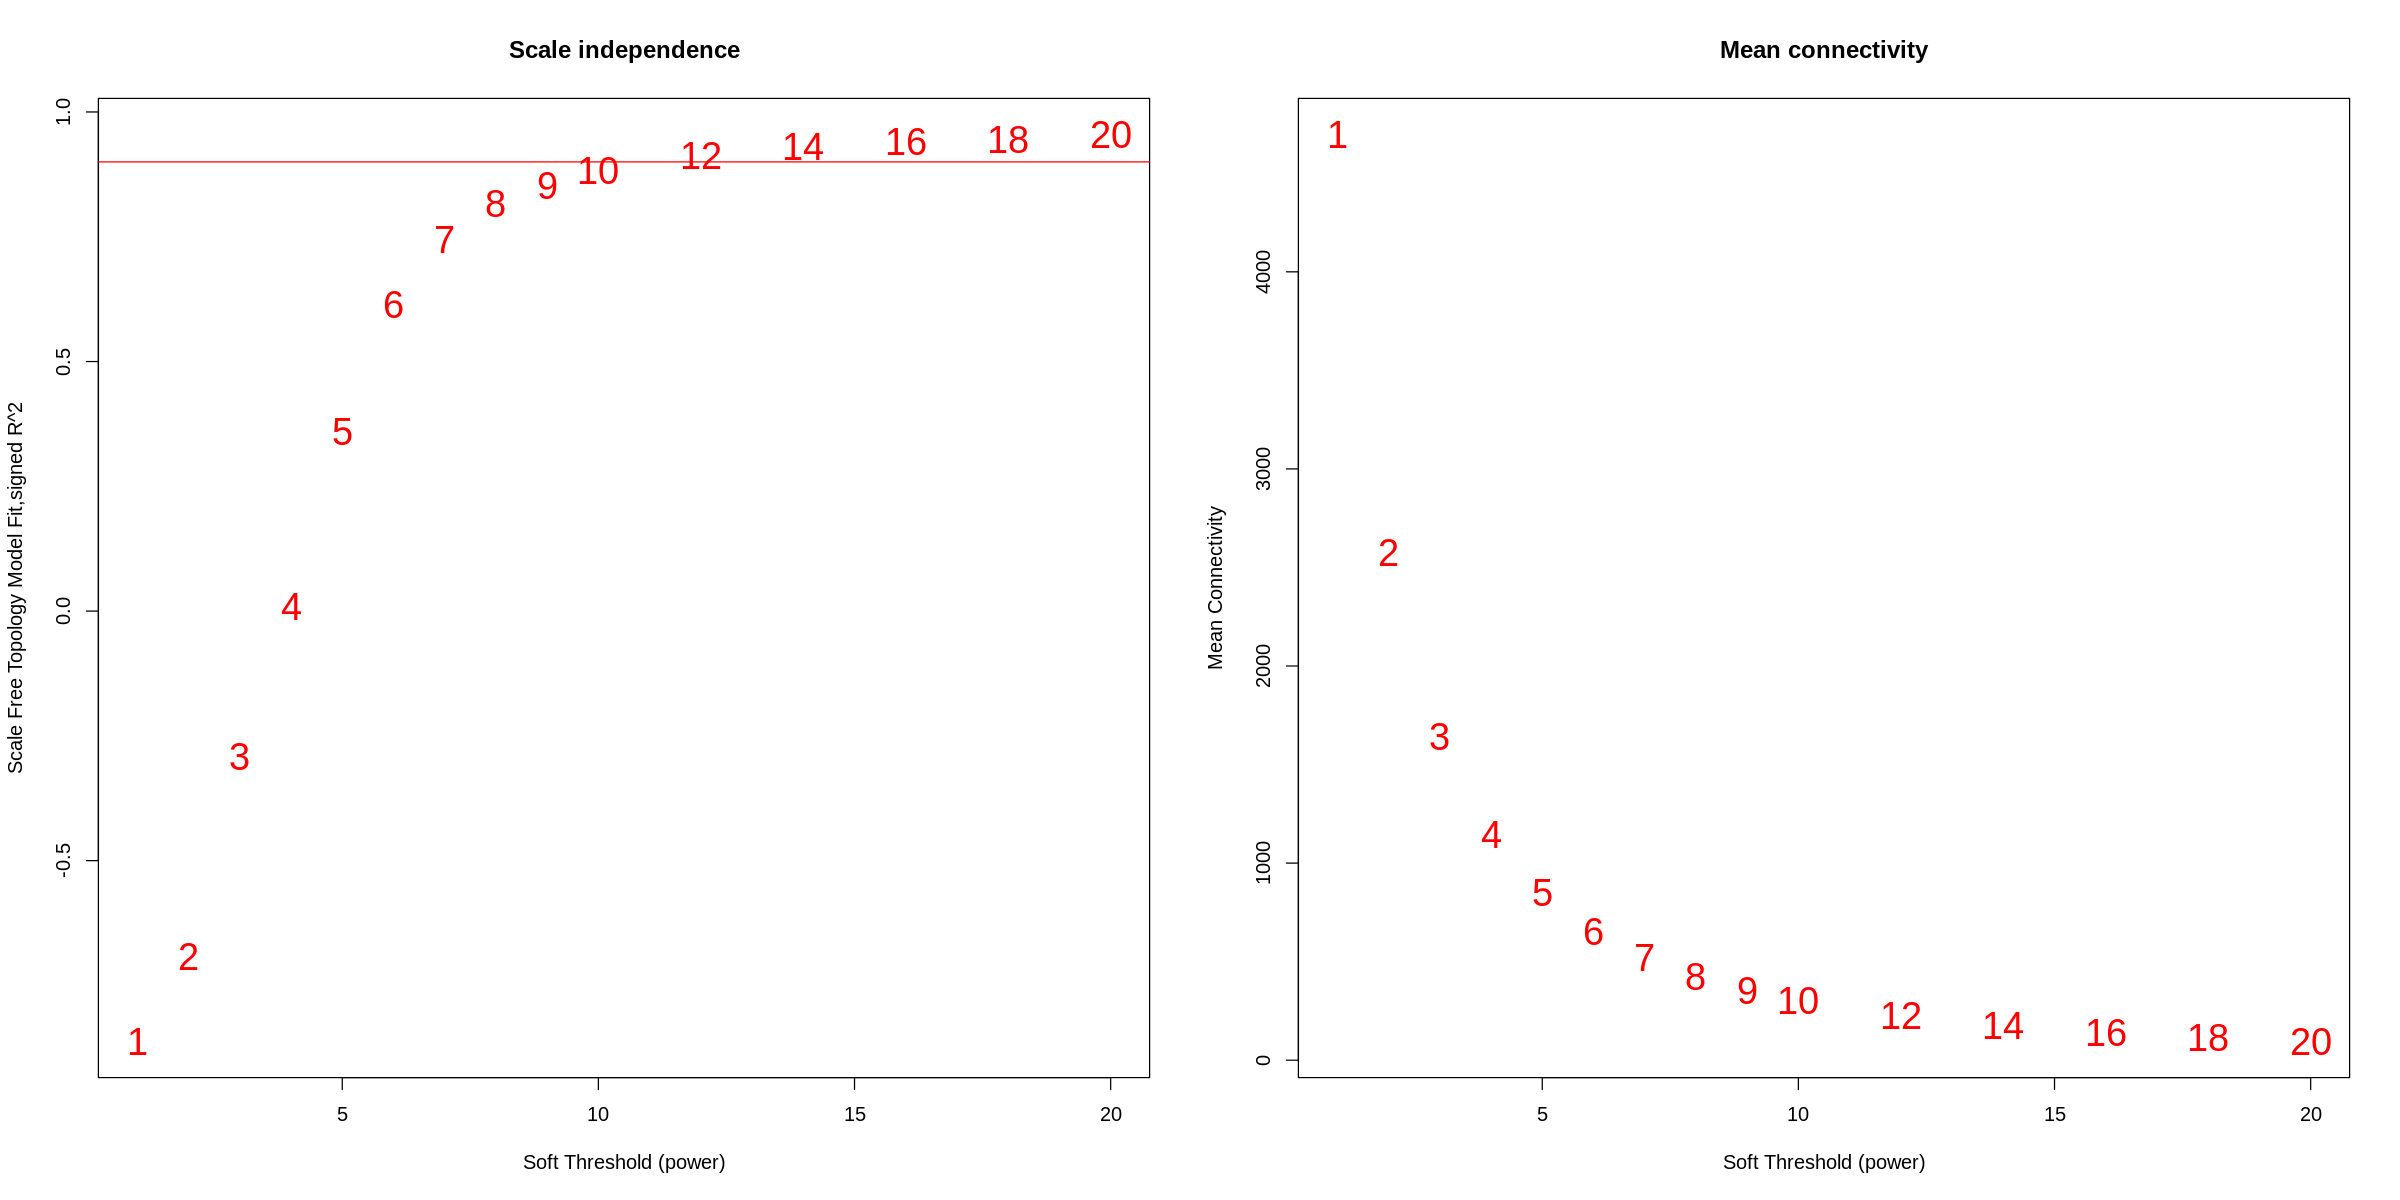

In [65]:
# Plot the results:
#sizeGrWindow(9, 5)
par(mfrow = c(1,2));
options(repr.plot.width=20, repr.plot.height=10)
cex1 = 1.9;

# Scale-free topology fit index as a function of the soft-thresholding power
plot(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
xlab="Soft Threshold (power)",ylab="Scale Free Topology Model Fit,signed R^2",type="n",
main = paste("Scale independence"));
text(sft$fitIndices[,1], -sign(sft$fitIndices[,3])*sft$fitIndices[,2],
labels=powers,cex=cex1,col="red");
# this line corresponds to using an R^2 cut-off of h
abline(h=0.90,col="red")

# Mean connectivity as a function of the soft-thresholding power
plot(sft$fitIndices[,1], sft$fitIndices[,5],
xlab="Soft Threshold (power)",ylab="Mean Connectivity", type="n",
main = paste("Mean connectivity"))
text(sft$fitIndices[,1], sft$fitIndices[,5], labels=powers, cex=cex1,col="red")

bla bla

In [67]:
# Runs 1 min in Google Colab
net <- blockwiseModules(t(dat.abundances2),
                        power = 12,
                        TOMType = "unsigned",
                        minModuleSize = 30,
                        reassignThreshold = 0,
                        mergeCutHeight = 0.25,
                        numericLabels = TRUE,
                        pamRespectsDendro = FALSE,
                        saveTOMs = TRUE,
                        saveTOMFileBase = "insulinMouseTOM",
                        verbose = 3)

 Calculating module eigengenes block-wise from all genes
   Flagging genes and samples with too many missing values...
    ..step 1
 ....pre-clustering genes to determine blocks..
   Projective K-means:
   ..k-means clustering..
   ..merging smaller clusters...
Block sizes:
gBlocks
   1    2    3 
4306 4268 3470 
 ..Working on block 1 .
    TOM calculation: adjacency..
    ..will use 2 parallel threads.
     Fraction of slow calculations: 0.000000
    ..connectivity..
    ..matrix multiplication (system BLAS)..
    ..normalization..
    ..done.
   ..saving TOM for block 1 into file insulinMouseTOM-block.1.RData
 ....clustering..
 ....detecting modules..
 ....calculating module eigengenes..
 ....checking kME in modules..
     ..removing 10 genes from module 1 because their KME is too low.
     ..removing 1 genes from module 2 because their KME is too low.
     ..removing 5 genes from module 5 because their KME is too low.
     ..removing 1 genes from module 11 because their KME is too l

How many modules were detected and how many phosphopeptides they have?

In [68]:
table(net$colors)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
  17 2344 1628 1518 1197  775  754  427  331  277  251  232  214  202  194  179 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
 154  134  131  114   89   86   83   80   65   63   60   60   58   52   50   42 
  32   33   34   35   36 
  41   39   38   33   32 

bla

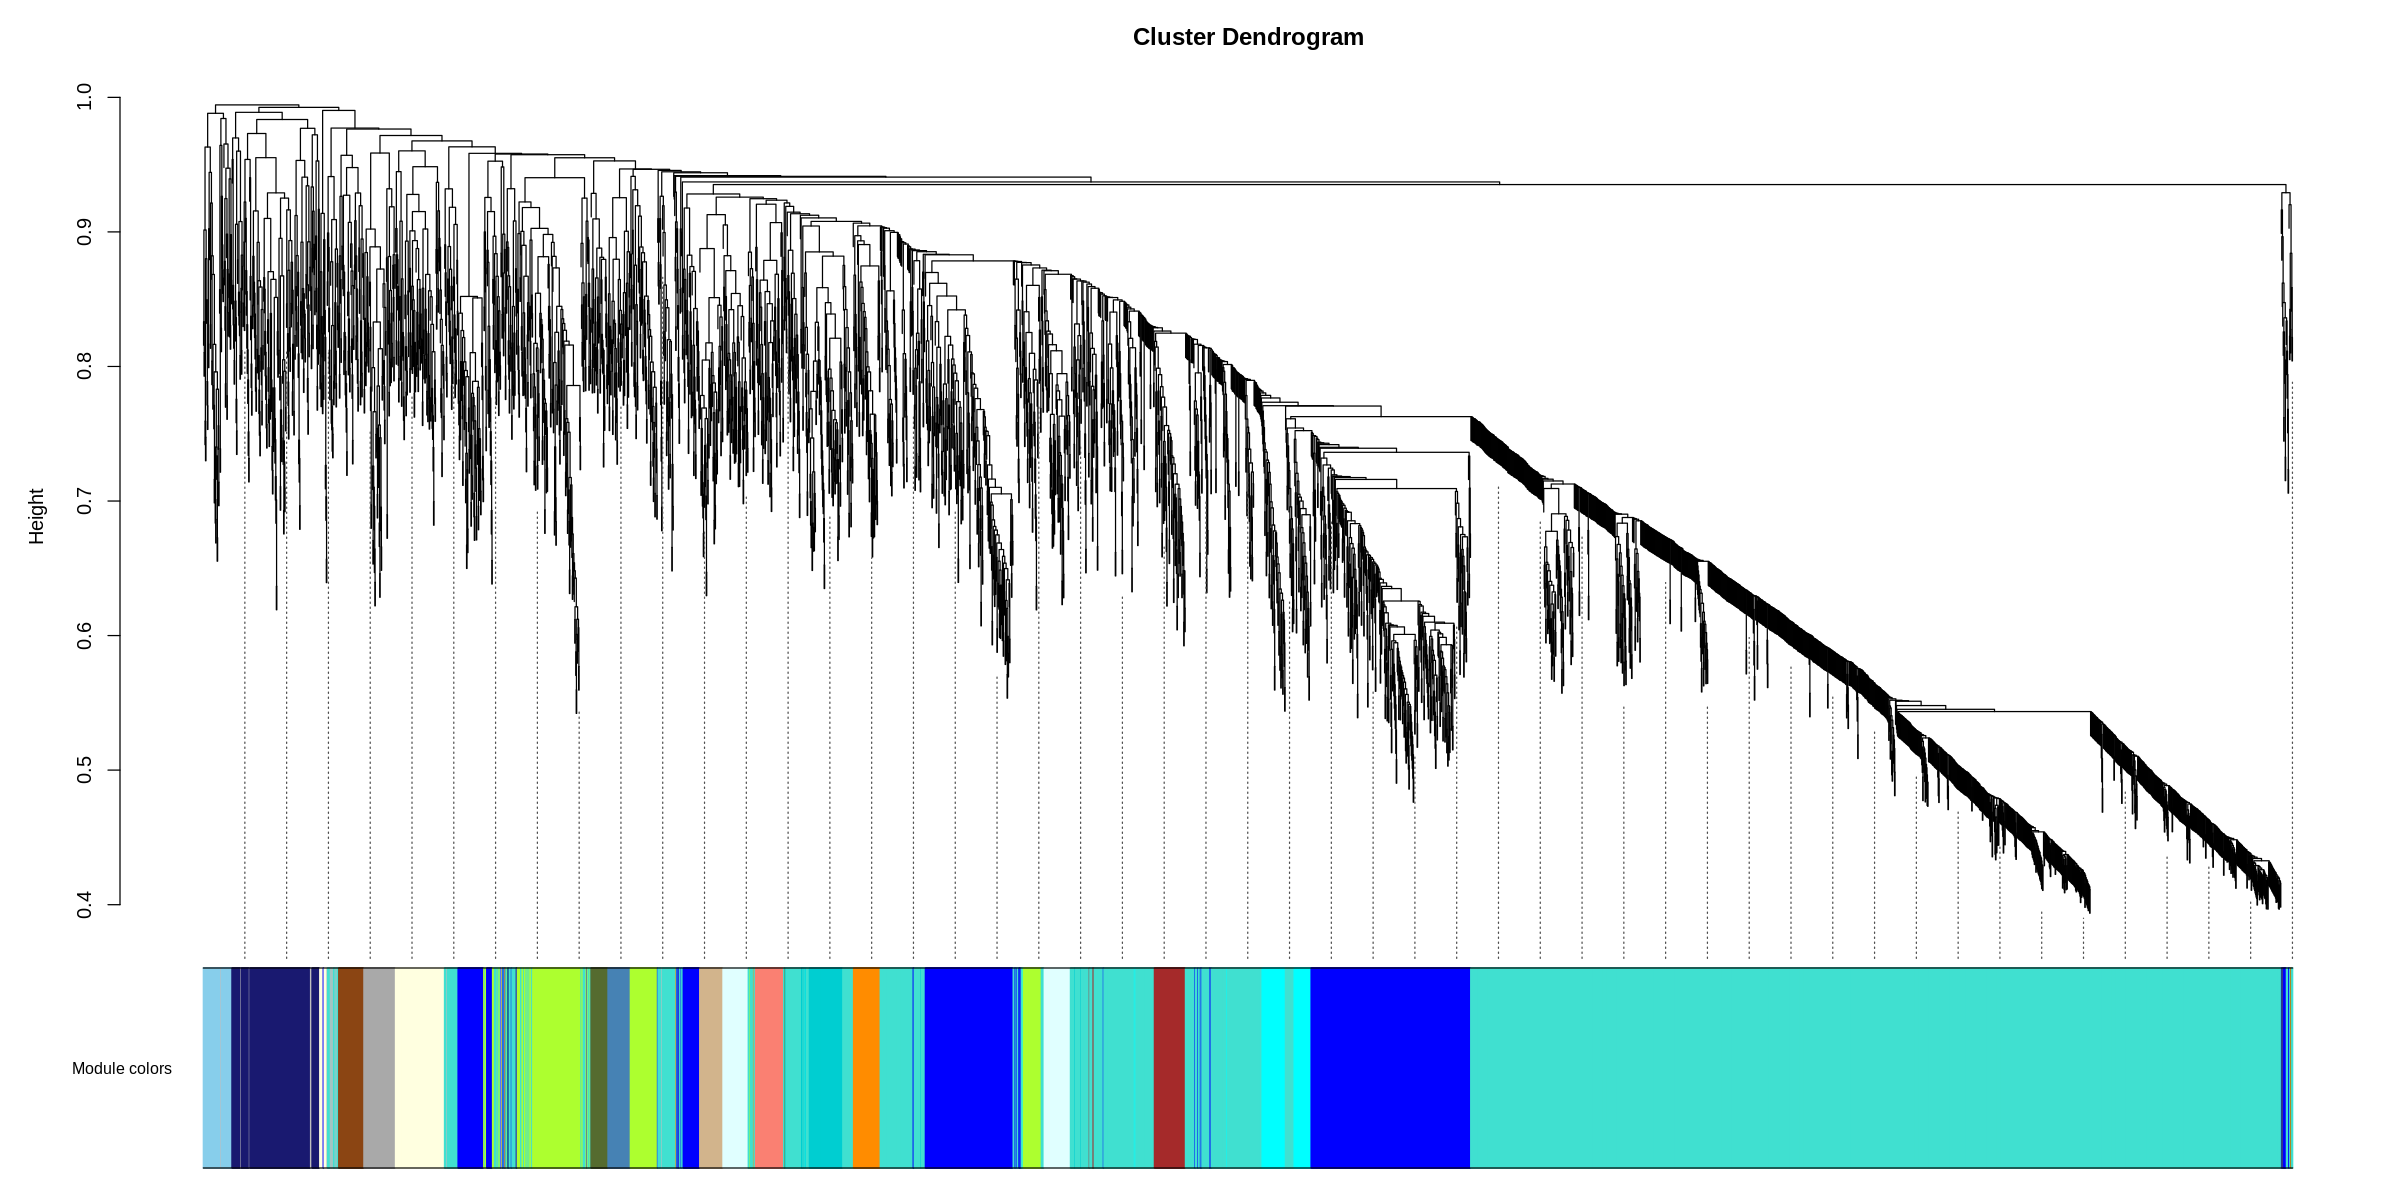

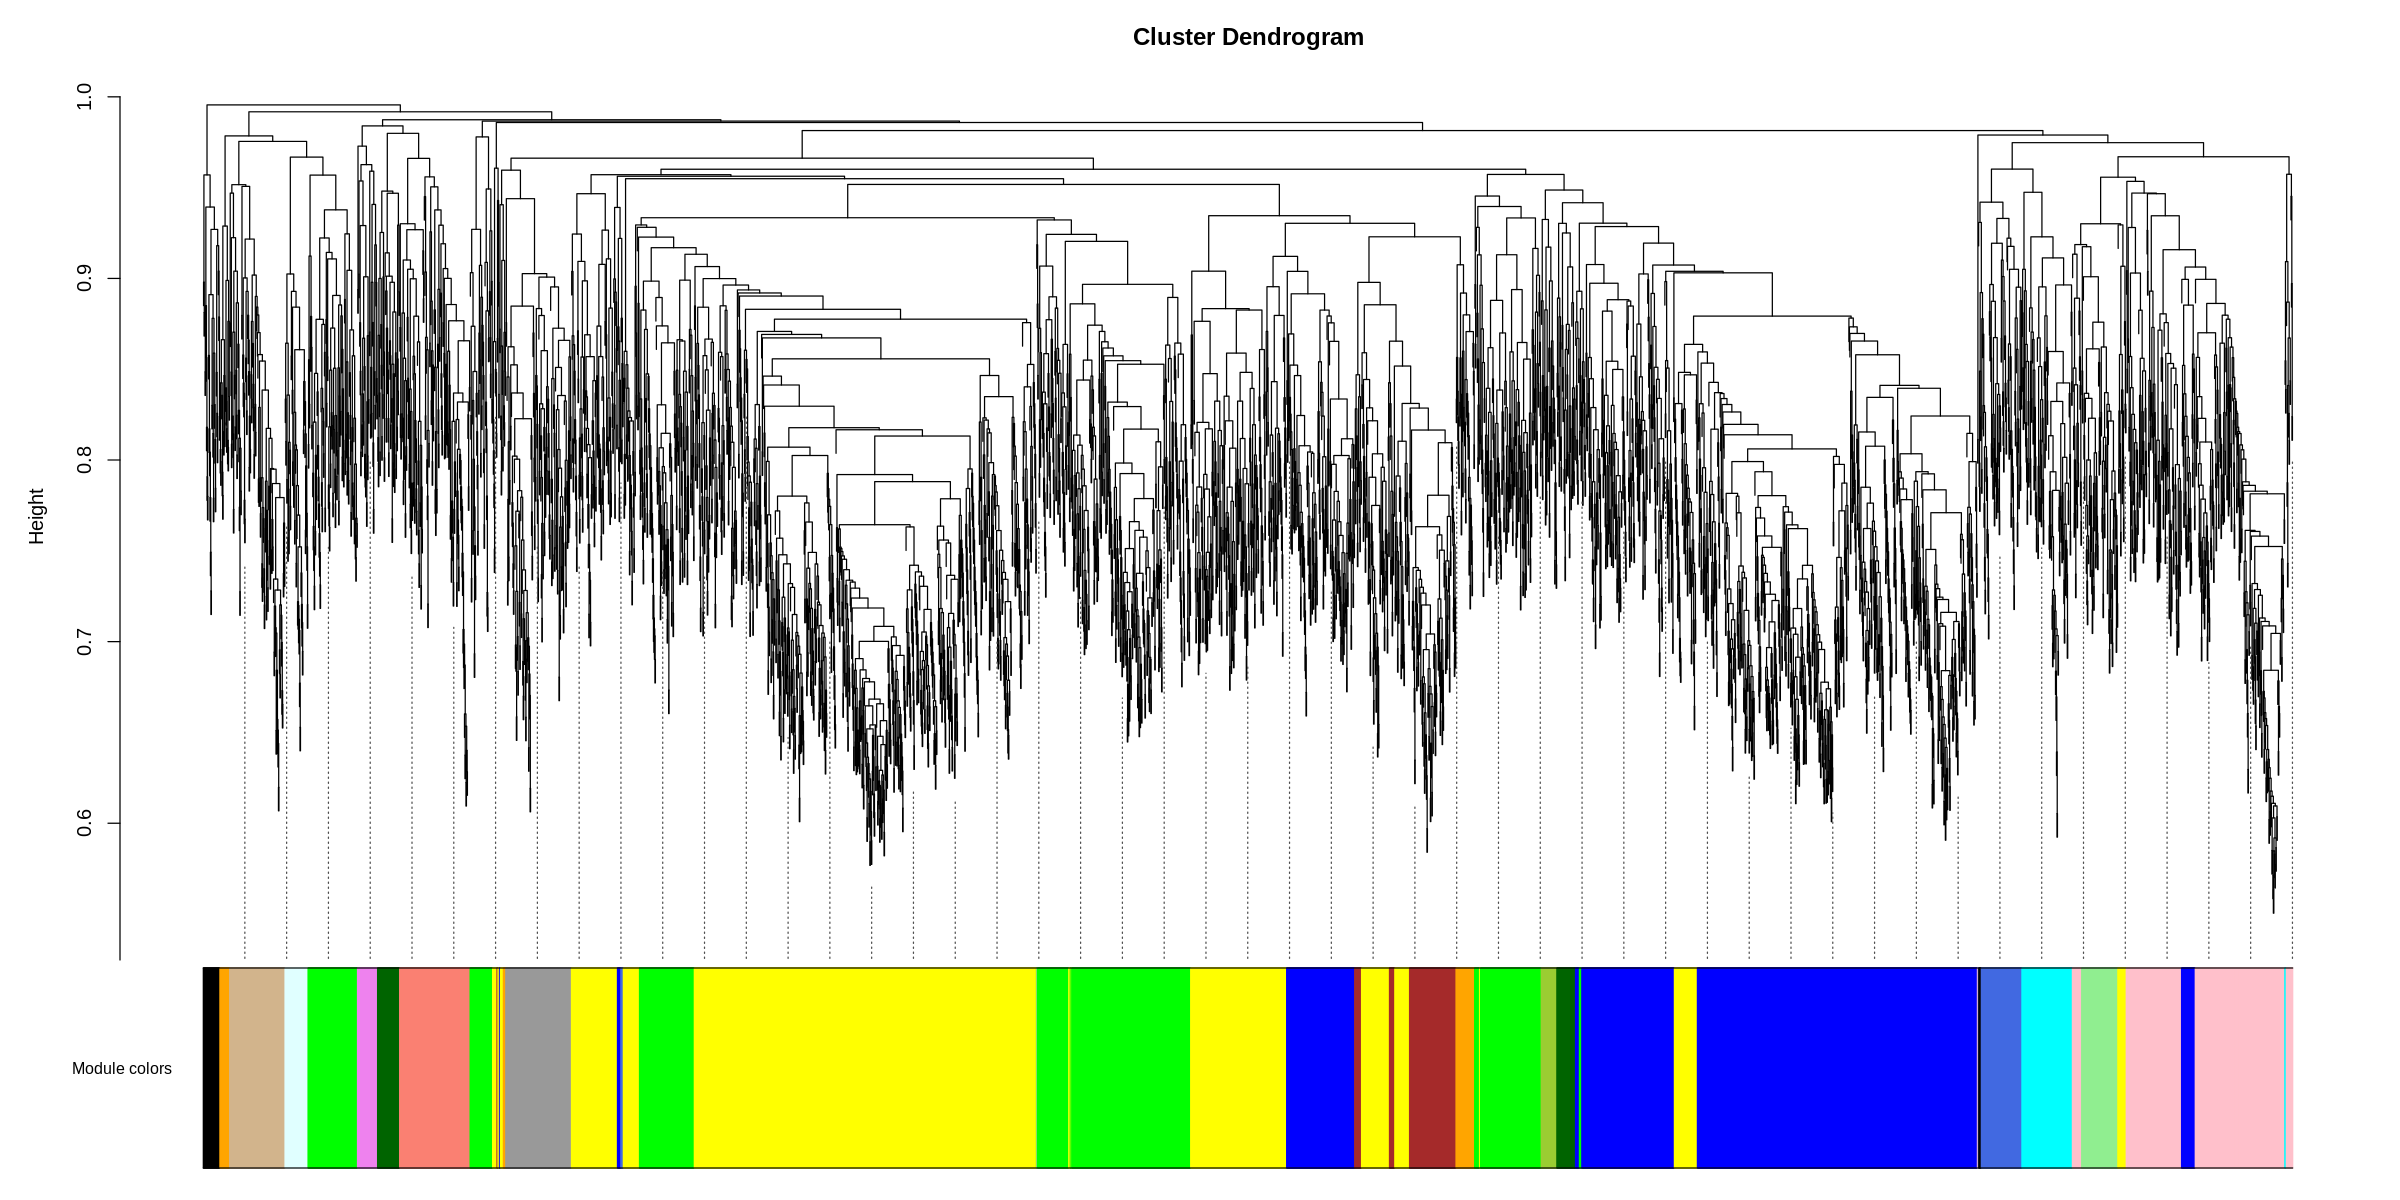

In [93]:
# Convert labels to colors for plotting
mergedColors <- labels2colors(net$colors)
# Plot the dendrogram and the module colors underneath
plotDendroAndColors(net$dendrograms[[1]],
                    mergedColors[net$blockGenes[[1]]],
                    "Module colors",
                    dendroLabels = FALSE,
                    hang = 0.03,
                    addGuide = TRUE,
                    guideHang = 0.05)

plotDendroAndColors(net$dendrograms[[2]],
                    mergedColors[net$blockGenes[[2]]],
                    "Module colors",
                    dendroLabels = FALSE,
                    hang = 0.03,
                    addGuide = TRUE,
                    guideHang = 0.05)


bla

In [92]:
labels2colors(net$colors)

module.idx <- labels2colors(net$colors) == 'magenta'
print(net$colors[module.idx])
module.ids <- names(net$colors[module.idx])

uniprot.ids2 <- c()
for(i in 1:length(module.ids)){
  #print(paste0("Original: ", module.ids[i]))
  tmp <- gsub("_peptide\\d+", "", module.ids[i])
  #print(paste0("After removing '_peptide\\d+': ", tmp))

  tmp <- gsub("-\\d+", "", tmp)
  #print(paste0("After removing '-\\d+': ", tmp))

  #tmp <- print(strsplit(tmp, "; "))
  tmp <- strsplit(tmp, "; ")
  #print("After splitting:")
  #print(tmp[[1]])
  uniprot.ids2 <- c(uniprot.ids2, tmp[[1]])

  #print("-----------------------")
}
uniprot.ids2 <- unique(uniprot.ids2)
print(uniprot.ids2)
print(length(uniprot.ids2))

write.table(x=uniprot.ids2, file="module.uniprot.ids.txt", quote=F, sep="\t", row.names=F, col.names=F)

[1] "red"            "magenta"        "turquoise"      "turquoise"     
    [5] "turquoise"      "turquoise"      "blue"           "yellow"        
    [9] "green"          "turquoise"      "magenta"        "blue"          
   [13] "yellow"         "turquoise"      "yellow"         "blue"          
   [17] "cyan"           "brown"          "blue"           "lightyellow"   
   [21] "yellow"         "yellow"         "turquoise"      "salmon"        
   [25] "lightgreen"     "yellow"         "turquoise"      "darkturquoise" 
   [29] "turquoise"      "lightgreen"     "brown"          "blue"          
   [33] "blue"           "brown"          "saddlebrown"    "yellow"        
   [37] "turquoise"      "turquoise"      "turquoise"      "black"         
   [41] "blue"           "darkturquoise"  "turquoise"      "tan"           
   [45] "blue"           "turquoise"      "pink"           "red"           
   [49] "blue"           "turquoise"      "magenta"        "brown"         
   [53] "turquoise"      "salmon"         "blue"           "blue"          
   [57] "yellow"         "red"            "yellow"         "turquoise"     
   [61] "turquoise"      "lightyellow"    "red"            "pink"          
   [65] "brown"          "midnightblue"   "yellow"         "green"         
   [69] "brown"          "turquoise"      "yellow"         "blue"          
   [73] "turquoise"      "red"            "red"            "pink"          
   [77] "green"          "turquoise"      "darkturquoise"  "royalblue"     
   [81] "turquoise"      "turquoise"      "magenta"        "purple"        
   [85] "turquoise"      "blue"           "turquoise"      "blue"          
   [89] "blue"           "red"            "red"            "cyan"          
   [93] "turquoise"      "yellow"         "yellow"         "turquoise"     
   [97] "black"          "black"          "brown"          "purple"        
  [101] "turquoise"      "turquoise"      "darkturquoise"  "yellow"        
  [105] "brown"          "yellow"         "turquoise"      "brown"         
  [109] "royalblue"      "yellow"         "brown"          "brown"         
  [113] "grey"           "black"          "turquoise"      "brown"         
  [117] "midnightblue"   "green"          "cyan"           "blue"          
  [121] "turquoise"      "blue"           "blue"           "grey60"        
  [125] "yellow"         "salmon"         "turquoise"      "yellow"        
  [129] "turquoise"      "red"            "lightcyan"      "lightgreen"    
  [133] "brown"          "greenyellow"    "blue"           "lightcyan"     
  [137] "turquoise"      "pink"           "turquoise"      "red"           
  [141] "blue"           "turquoise"      "turquoise"      "salmon"        
  [145] "brown"          "blue"           "yellow"         "yellow"        
  [149] "skyblue"        "turquoise"      "yellow"         "brown"         
  [153] "salmon"         "yellow"         "salmon"         "green"         
  [157] "red"            "turquoise"      "brown"          "grey60"        
  [161] "turquoise"      "lightgreen"     "brown"          "greenyellow"   
  [165] "lightyellow"    "darkorange"     "turquoise"      "skyblue"       
  [169] "paleturquoise"  "brown"          "blue"           "red"           
  [173] "black"          "blue"           "lightyellow"    "green"         
  [177] "yellow"         "brown"          "magenta"        "tan"           
  [181] "darkmagenta"    "brown"          "darkgrey"       "brown"         
  [185] "green"          "green"          "brown"          "red"           
  [189] "midnightblue"   "brown"          "blue"           "brown"         
  [193] "turquoise"      "green"          "blue"           "darkred"       
  [197] "brown"          "lightyellow"    "blue"           "darkgreen"     
  [201] "lightgreen"     "yellow"         "turquoise"      "salmon"        
  [205] "turquoise"      "brown"          "darkgreen"      "darkolivegreen"
  [209] "pink"           "lightyellow"    "pink"    

                                        Q6GQX2_peptide1 
                                                      9 
                                        Q6GQX2_peptide2 
                                                      9 
                                        Q8VC03_peptide1 
                                                      9 
                                        Q80XU3_peptide1 
                                                      9 
                                        Q9ESX5_peptide1 
                                                      9 
                                        Q99K70_peptide2 
                                                      9 
                                      Q08122-1_peptide1 
                                                      9 
                                        Q62511_peptide1 
                                                      9 
                                        Q8BH93_peptide1 
                               